## M2 - release: regressions

### Setup

#### Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import learning_curve

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import RFE

from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

sns.set_theme()
# Show plots
viz = True

In [2]:
class Feats():
    """
    Each feature has a first name, optionally a second name, a statistic and a number.
    This class allows to group feautures according to these aspects or combinations of these aspects.
    Each method produces a list of feature names or a list of lists of feature names.
    """

    def __init__(self, csv):
        self.fts = pd.read_csv(csv, dtype={'n':"string"})
        self.fts = self.fts.fillna('')

    def format(self, select):
        return select.apply(lambda x: '_'.join(x).replace('__', '_'), axis=1).tolist()

    def all(self):
        select = self.fts.copy()
        return self.format(select)

fts = Feats('features.csv')

#### Data

In [3]:
# Load fold f5
df_train = pd.read_csv('data/fold/f5_train.csv',  parse_dates=['release'])
df_train = df_train.drop(columns=['popularity'])
df_test = pd.read_csv('data/fold/f5_test.csv',  parse_dates=['release'])
df_test = df_test.drop(columns=['popularity'])
print(f'train set: {df_train.shape[0]:,} entries, test set: {df_test.shape[0]:,} entries, total: {df_train.shape[0]+df_test.shape[0]:,} entries')

train set: 68,208 entries, test set: 17,051 entries, total: 85,259 entries


### Preprocessing

In [4]:
# Drop NA values
n_orig = df_train.shape[0]
n_na = df_train['release'].isna().sum()
df_train = df_train.dropna(subset=['release'])
n_orig = df_test.shape[0]
n_na = df_test['release'].isna().sum()
df_test = df_test.dropna(subset=['release'])

# Bin y per year
df_train['release'] = df_train['release'].dt.year.astype(int)
df_test['release'] = df_test['release'].dt.year.astype(int)

# Throw out values <1980
y_train_before = df_train['release']
n_orig = df_train.shape[0]
n_under = df_train.loc[df_train['release']<1995].shape[0]
df_train = df_train.loc[df_train['release']>=1995]
y_train = df_train['release']
n_orig = df_test.shape[0]
n_under = df_test.loc[df_test['release']<1995].shape[0]
df_test = df_test.loc[df_test['release']>=1995]
y_test = df_test['release']

# Scale y
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)
scaler = StandardScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_train = pd.Series(y_train.reshape(1, -1)[0])
y_test = scaler.transform(y_test)
y_test = pd.Series(y_test.reshape(1, -1)[0])

# Scale X
X_train = df_train.drop(columns=['release'])
X_test = df_test.drop(columns=['release'])
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=fts.all())
X_test = pd.DataFrame(X_test, columns=fts.all())

# Use RFE to reduce features
estimator = LinearRegression()
red = RFE(estimator, n_features_to_select=45, step=5).fit(X_train, y_train)
X_train = red.transform(X_train)
X_test = red.transform(X_test)
cols = [x for x, y in zip(fts.all(), red.support_.tolist()) if y]
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

X_train


,chroma_cens_median_01,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_mean_02,chroma_cens_mean_09,chroma_cens_kurtosis_04,chroma_cens_kurtosis_09,...,spectral_contrast_median_06,spectral_contrast_mean_01,spectral_contrast_kurtosis_03,spectral_rolloff_max_01,spectral_rolloff_median_01,spectral_rolloff_mean_01,spectral_rolloff_kurtosis_01,tonnetz_median_04,zcr_median_01,zcr_std_01
0,2.163690,0.063557,0.068009,0.284101,0.384085,-1.011202,1.350241,0.379968,-0.998535,-0.491921,...,-0.685327,-0.958760,0.604617,0.250729,0.644108,-0.405118,2.567951,1.578509,-0.287218,-0.484304
1,-0.125133,1.020308,0.604760,-0.080676,-0.051676,-0.082517,0.047253,-0.139718,-0.551031,-0.678143,...,-0.377526,-0.591520,-0.343809,0.004375,-0.011693,-0.009614,-0.447535,-0.135208,0.092691,-0.484304
2,-0.101143,-1.133795,0.096617,0.642099,-0.326703,-0.806437,-0.174148,1.181264,1.714325,0.913136,...,-0.705155,0.344312,-0.000364,0.111485,0.249171,0.175515,-0.048386,-0.074432,-0.673030,-0.484304
3,0.198682,0.189891,0.432111,0.312344,-0.014410,-0.007950,0.815597,0.217202,-0.756794,-0.879229,...,0.722954,-1.683976,1.077514,0.486372,0.633100,0.554190,-0.190870,-0.230317,1.054822,-0.484304
4,-0.203342,-0.035711,0.925454,0.393734,0.301963,0.527410,-0.212531,0.289036,0.097370,0.581156,...,-0.361231,0.595413,-0.198167,1.418235,1.408567,1.538743,1.480744,-0.616923,1.459849,-0.484304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44712,1.288302,0.296283,-0.194860,-0.147984,-0.670032,-0.370581,1.289223,-0.217785,-1.150715,-1.075375,...,-0.489921,-0.383904,1.344300,0.347129,1.846864,1.732287,0.025476,0.655588,0.226904,-0.484304
44713,-0.817932,0.540023,0.642790,0.825770,-0.621604,0.448423,-1.270679,1.216811,-0.502664,0.340001,...,-0.056351,0.666323,-0.548948,0.197174,0.135953,0.192345,-0.454876,0.398315,0.115437,0.655900
44714,-0.839786,0.541347,0.005178,0.280962,0.497225,0.322370,0.007652,0.266294,-0.156089,0.109493,...,-0.175291,2.035206,0.525320,0.314995,-0.296977,-0.320969,-0.449898,-0.363225,0.124293,-0.484304
44715,-1.771123,-0.959793,1.873970,0.922774,-0.998372,-0.712687,-0.120254,1.128333,-0.618360,-0.877763,...,0.934046,1.626480,0.263777,0.400684,-1.103838,-0.952092,-0.949535,-2.227622,-0.517780,1.070520


### Models

In [18]:
scores = {}

In [6]:
def plt_curve(title, train_sizes, train_scores, test_scores, fit_times):
    """
    Code based on scikit learn example: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    """
    # Values
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Init fig
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

    # Plot learning curve
    axes[0].set_title(f'Learning curve (R2): {title}')
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes[0].legend(loc="best")
    
    # Plot n_samples vs fit_times
    axes[1].set_title("Scalability of the model")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    
    # Plot fit_time vs score
    axes[2].set_title("Performance of the model")
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(fit_time_sorted, test_scores_mean_sorted - test_scores_std_sorted, test_scores_mean_sorted + test_scores_std_sorted, alpha=0.1)

    # Show fig
    axes[0].grid()
    axes[1].grid()
    axes[2].grid()
    plt.show()

#### Linear regression

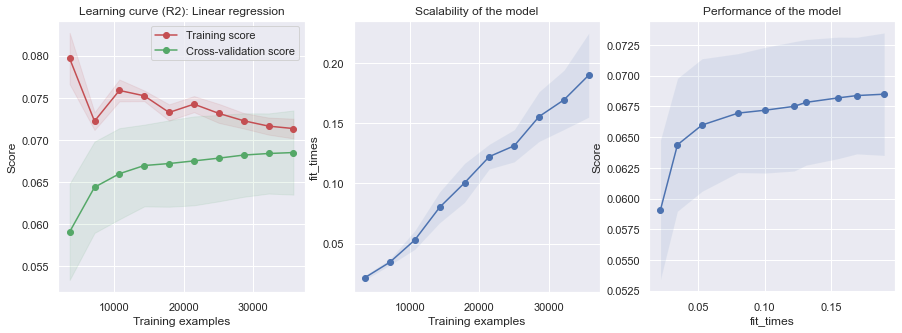

In [7]:
title = "Linear regression"
estimator = LinearRegression()
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, return_times=True)

plt_curve(title, train_sizes, train_scores, test_scores, fit_times)

In [19]:
name = 'linear_regression'

# Subsample according to performance analysis with learning curve
idx_train = X_train.sample(frac=1, random_state=1).index
X_train_sub = X_train.iloc[idx_train]
y_train_sub = y_train.iloc[idx_train]
idx_test = X_test.sample(frac=1, random_state=1).index
X_test_sub = X_test.iloc[idx_test]
y_test_sub = y_test.iloc[idx_test]

model = LinearRegression().fit(X_train_sub, y_train_sub)
y_pred = model.predict(X_test_sub)

scores[name] = {
    'R2_train': round(model.score(X_train_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test_sub, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test_sub, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test_sub, y_pred), 6),
}

#### Elastic net

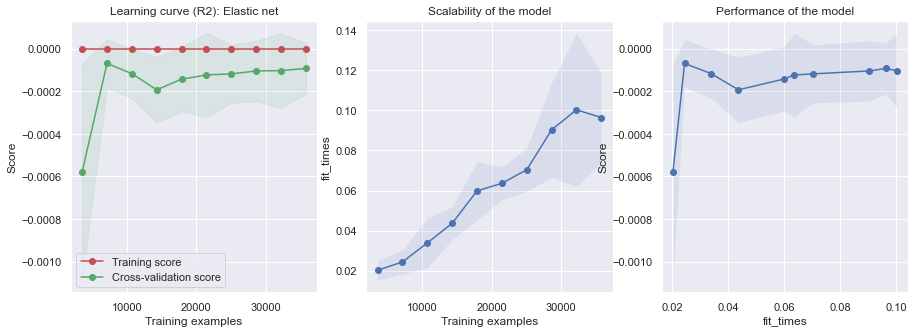

In [9]:
title = "Elastic net"
estimator = ElasticNet()
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, return_times=True)

plt_curve(title, train_sizes, train_scores, test_scores, fit_times)

In [20]:
name = 'elastic_net'

# Subsample according to performance analysis with learning curve
idx_train = X_train.sample(frac=1, random_state=1).index
X_train_sub = X_train.iloc[idx_train]
y_train_sub = y_train.iloc[idx_train]
idx_test = X_test.sample(frac=1, random_state=1).index
X_test_sub = X_test.iloc[idx_test]
y_test_sub = y_test.iloc[idx_test]

model = ElasticNet().fit(X_train_sub, y_train_sub)
y_pred = model.predict(X_test_sub)

scores[name] = {
    'R2_train': round(model.score(X_train_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test_sub, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test_sub, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test_sub, y_pred), 6),
}

#### Polynomial regression

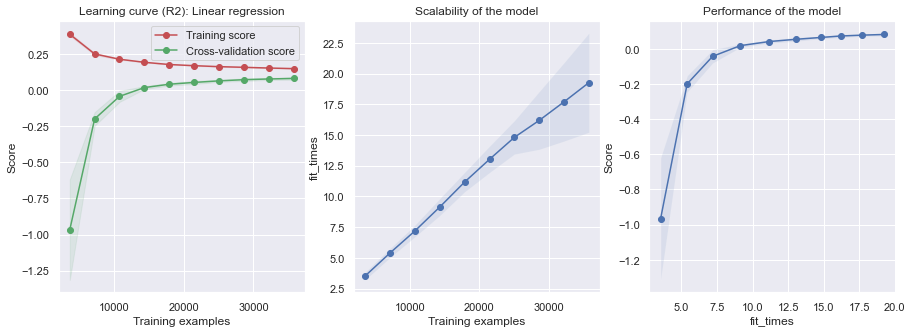

In [11]:
title = "Linear regression"
estimator = LinearRegression()
train_sizes = np.linspace(0.1, 1.0, 10)

poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train))
X_test_poly = pd.DataFrame(poly.fit_transform(X_test))
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train_poly, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, return_times=True)

plt_curve(title, train_sizes, train_scores, test_scores, fit_times)

In [21]:
name = 'poly_linear_regression'

# Subsample according to performance analysis with learning curve
idx_train = X_train_poly.sample(frac=1, random_state=1).index
X_train_sub = X_train_poly.iloc[idx_train]
y_train_sub = y_train.iloc[idx_train]
idx_test = X_test_poly.sample(frac=1, random_state=1).index
X_test_sub = X_test_poly.iloc[idx_test]
y_test_sub = y_test.iloc[idx_test]

model = LinearRegression().fit(X_train_sub, y_train_sub)
y_pred = model.predict(X_test_sub)

scores[name] = {
    'R2_train': round(model.score(X_train_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test_sub, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test_sub, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test_sub, y_pred), 6),
}

#### SVR - support vector regression

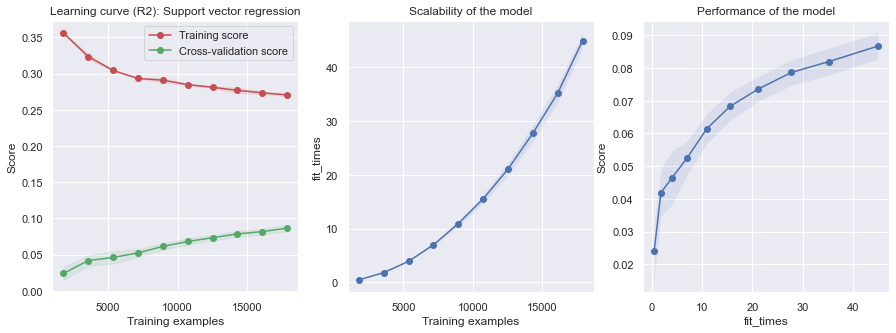

In [15]:
title = "Support vector regression"
estimator = SVR()
train_sizes = np.linspace(0.05, 0.5, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, return_times=True)

plt_curve(title, train_sizes, train_scores, test_scores, fit_times)

In [22]:
name = 'svr'

# Subsample according to performance analysis with learning curve
idx_train = X_train.sample(frac=0.5, random_state=1).index
X_train_sub = X_train.iloc[idx_train]
y_train_sub = y_train.iloc[idx_train]
idx_test = X_test.sample(frac=0.5, random_state=1).index
X_test_sub = X_test.iloc[idx_test]
y_test_sub = y_test.iloc[idx_test]

model = SVR().fit(X_train_sub, y_train_sub)
y_pred = model.predict(X_test_sub)

scores[name] = {
    'R2_train': round(model.score(X_train_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test_sub, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test_sub, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test_sub, y_pred), 6),
}

#### K-neighbors regression

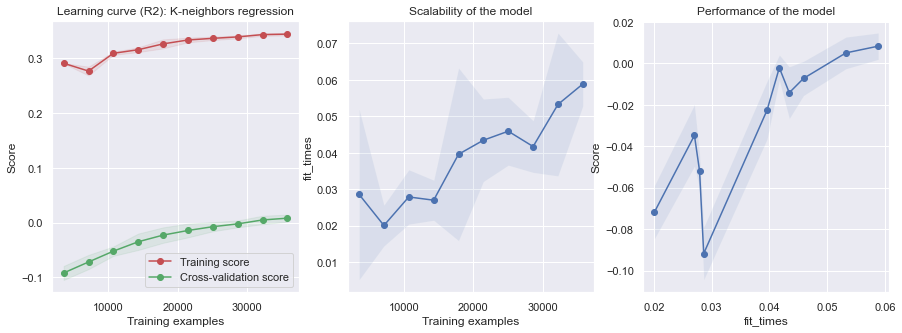

In [13]:
title = "K-neighbors regression"
estimator = KNeighborsRegressor()
train_sizes = np.linspace(0.1, 1, 10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, return_times=True)

plt_curve(title, train_sizes, train_scores, test_scores, fit_times)

In [23]:
name = 'k-neighbors'

# Subsample according to performance analysis with learning curve
idx_train = X_train.sample(frac=0.5, random_state=1).index
X_train_sub = X_train.iloc[idx_train]
y_train_sub = y_train.iloc[idx_train]
idx_test = X_test.sample(frac=0.5, random_state=1).index
X_test_sub = X_test.iloc[idx_test]
y_test_sub = y_test.iloc[idx_test]

model = KNeighborsRegressor().fit(X_train_sub, y_train_sub)
y_pred = model.predict(X_test_sub)

scores[name] = {
    'R2_train': round(model.score(X_train_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test_sub, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test_sub, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test_sub, y_pred), 6),
}

#### Results

In [24]:
pd.DataFrame.from_dict(scores, orient='index')

,R2_train,R2_test,MSE_test,MAE_test
linear_regression,0.071084,0.068294,0.948933,0.745997
elastic_net,0.000000,-0.000212,1.018705,0.773247
poly_linear_regression,0.144053,0.094490,0.922253,0.732113
svr,0.268218,0.111146,0.870903,0.700626
k-neighbors,0.330818,0.007178,0.972771,0.752084
